# NHL Scoring Event Network Analysis

Samuli Kinnunen | Madhav Narendran

This notebook was created as part of the course Network Analysis at the University of Helsinki in Spring 2020. It allows you to visualize scoring events for an NHL team as a weighted and directed graph. The functions defined below allow you to produce a graph for a single game or an animation depiciting a full season.


In [0]:
import pickle
import networkx as nx
from networkx import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import requests
import json
import imageio


In [0]:
def generate_all_teams(season):
  teamsreq = requests.get("https://statsapi.web.nhl.com/api/v1/teams")
  teams = json.loads(teamsreq.text)
  teamsLU = pd.DataFrame.from_dict(teams['teams']).loc[:,['id','name', 'link','abbreviation']]
  team_list = teamsLU['name'].tolist()

  for team in team_list:
    G = generate_network(team, season)
    team_name = team + '_20182019' + '.gpickle'
    nx.write_gpickle(G , team_name)

def generate_network_evolution(teamCityName, season):
  #get data from API
  teamsreq = requests.get("https://statsapi.web.nhl.com/api/v1/teams")
  teams = json.loads(teamsreq.text)
  teamsLU = pd.DataFrame.from_dict(teams['teams']).loc[:,['id','name', 'link','abbreviation']]
  teamId = teamsLU[teamsLU['name'].str.contains(teamCityName)]['id'].values[0]
  sched = getSched(season, str(teamId))
  list_of_attr_df = []
  list_of_game_df = []
  list_of_graphs = []
  #Going through all the games in the season
  for i, gId in enumerate(sched.gamePk):
    try:
      homeFlag = sched.home_flag[i]
      gameData = getGameData(str(gId), teamId)
      attrData = make_attribute_df(gId, homeFlag)
      list_of_attr_df.append(attrData)
      if gameData.empty:
        pass
      else:
        game_df = make_score_df(gameData)
        list_of_game_df.append(game_df)
    except:
      pass

    concat_df = concat_game_df(list_of_game_df)
    concat_df = concat_df.to_frame()
    attributes  = concat_attr_df(list_of_attr_df)
    attributes['points'] = attributes['goals'] + attributes['assists']
    attributes_dict = attributes.to_dict('index')
    G = nx.from_pandas_edgelist(concat_df.reset_index(), 'scorer', 'assist', 'weight',create_using=nx.DiGraph())
    nx.set_node_attributes(G, attributes_dict)
    list_of_graphs.append(G)
    #nx.write_gpickle(G,'flames2018_' + str(i) +'.gpickle')

  return list_of_graphs

def generate_network(teamCityName, season):
  #get data from API
  teamsreq = requests.get("https://statsapi.web.nhl.com/api/v1/teams")
  teams = json.loads(teamsreq.text)
  teamsLU = pd.DataFrame.from_dict(teams['teams']).loc[:,['id','name', 'link','abbreviation']]
  teamId = teamsLU[teamsLU['name'].str.contains(teamCityName)]['id'].values[0]
  sched = getSched(season, str(teamId))
  list_of_attr_df = []
  list_of_game_df = []
  #Going through all the games in the season
  for i, gId in enumerate(sched.gamePk):
    homeFlag = sched.home_flag[i]
    try:
      gameData = getGameData(str(gId), teamId)
      attrData = make_attribute_df(gId, homeFlag)
      list_of_attr_df.append(attrData)
      
      if gameData.empty:
        pass
      else:
        game_df = make_score_df(gameData)
        list_of_game_df.append(game_df)
    
    except:
      pass

  concat_df = concat_game_df(list_of_game_df)
  concat_df = concat_df.to_frame()
  attributes  = concat_attr_df(list_of_attr_df)
  attributes['points'] = attributes['goals'] + attributes['assists']
  attributes_dict = attributes.to_dict('index')
  print(list_of_game_df[0])
  
  G = nx.from_pandas_edgelist(concat_df.reset_index(), 'scorer', 'assist', 'weight',create_using=nx.DiGraph())
  nx.set_node_attributes(G, attributes_dict)

  return G

def make_attribute_df(game_id, home_or_not):
  if home_or_not == 1:
    side = "home"
  else:
    side = "away"
  response = requests.get("https://statsapi.web.nhl.com/api/v1/game/" + str(game_id) + "/boxscore")
  game = json.loads(response.text)
  list_of_players = game['teams'][side]['players'].keys()
  list_of_timeOnIce = []
  list_of_plusMinus = []
  list_of_players_with_stats = []
  list_of_goals = []
  list_of_assists = []
  list_of_shots = []
  list_of_position = []
  for player in list_of_players:
    try:
      stats = game['teams'][side]['players'][player]['stats']['skaterStats']
      fullName = game['teams'][side]['players'][player]['person']['fullName']
      position = game['teams'][side]['players'][player]['position']['type']
      assists = stats['assists']
      goals = stats['goals']
      shots = stats['shots']
      timeOnIce = stats['timeOnIce']
      plusMinus = stats['plusMinus']
      list_of_timeOnIce.append(timeOnIce)
      list_of_plusMinus.append(plusMinus)
      list_of_players_with_stats.append(fullName)
      list_of_goals.append(goals)
      list_of_assists.append(assists)
      list_of_shots.append(shots)
      list_of_position.append(position)
    except:
      continue
  players_attr = pd.DataFrame({'player': list_of_players_with_stats, 'timeOnIce':list_of_timeOnIce, 'plusMinus':list_of_plusMinus, 'assists' : list_of_assists, 'goals' : list_of_goals, 'shots':list_of_shots, 'position':list_of_position})
  players_attr['timeOnIce'] = players_attr['timeOnIce'].apply(lambda x: int(x.split(":")[0])*60+int(x.split(":")[1]))
  return players_attr

def attribute_df_to_dict(df):
  df = df.set_index('player')
  attr_dict = df.to_dict('index')
  return attr_dict

def make_score_df(network_pre):
  #dropping columns that are not needed
  try:
    network_pre = network_pre[['scorer_fullName', 'assist1_fullName', 'assist2_fullName']]
  except:
    try:
      network_pre = network_pre[['scorer_fullName', 'assist1_fullName']]
      network_pre['assist2_fullName'] = None
    except:
      network_pre = network_pre[['scorer_fullName']]
      network_pre['assist1_fullName'] = None
      network_pre['assist2_fullName'] = None
  
  #making own dataframes from both first and second assist, giving different weights for each
  network_first_assist = network_pre.drop(['assist2_fullName'], axis=1)
  network_first_assist['weight'] = 1
  network_sec_assist = network_pre.drop(['assist1_fullName'], axis=1)
  network_sec_assist['weight'] = 0.5
  

  #renaming dfs to have same names for columns
  network_first_assist = network_first_assist.rename(columns={"scorer_fullName": "scorer", "assist1_fullName": "assist"})
  network_sec_assist = network_sec_assist.rename(columns={"scorer_fullName": "scorer", "assist2_fullName": "assist"})
  
  #concatinating frames into a single frame
  frames = [network_first_assist, network_sec_assist]
  network = pd.concat(frames)
  network = network[network['assist']!= None]
  return network

def getSched (season, teamId):  
  schedresp = requests.get(f"https://statsapi.web.nhl.com/api/v1/schedule?season={season}&gameType=R&teamId={teamId}")
  schedData = json.loads(schedresp.text)

  sched = pd.DataFrame.from_dict(schedData)
  sched = [d['games'] for d in sched['dates']]
  sched = [y for x in sched for y in x]
  sched = pd.DataFrame(sched)
  sched = pd.concat([sched[['gamePk','gameType','season']],
            sched.teams.apply(pd.Series).home.apply(pd.Series).team.apply(pd.Series).add_prefix('home_'),
            sched.teams.apply(pd.Series).away.apply(pd.Series).team.apply(pd.Series).add_prefix('away_')],
            axis=1)
  sched['home_flag'] = sched['home_id'].apply(lambda x: 1 if str(x) == teamId else 0)
  return sched

def getGameData (gId, teamId):

  response = requests.get(f"https://statsapi.web.nhl.com/api/v1/game/{gId}/feed/live")
  game = json.loads(response.text)

  scoringPlayId = game['liveData']['plays']['scoringPlays']
  gameData = pd.DataFrame.from_dict(game['liveData']['plays']['allPlays'])

  players = pd.DataFrame()

  temp = gameData.iloc[scoringPlayId]
  # print("\nT1\n"2018020003,temp.head())
  if temp.empty:
    return players 

  scoringPlays = pd.concat([temp['about'].apply(pd.Series)], axis = 1)

  cols = ['scorer', 'assist1', 'assist2', 'goalie', 
          'teamId', 'teamName', 'teamLink', 'teamCode']

  temp2 = pd.concat([pd.DataFrame(temp.players.apply(pd.Series)),
                    pd.DataFrame(temp.team.apply(pd.Series))],axis=1)
  
  if len(list(temp2.columns)) == 7:
      cols = ['scorer', 'assist1', 'assist2', 
          'teamId', 'teamName', 'teamLink', 'teamCode']

  temp2.columns = cols
  temp2 = temp2[temp2.teamId == teamId]

  

  if temp2.empty:
    return players  

  # print("\nT2\n", temp2.head())

  for c in cols[0:3]:
    temp3 = temp2[c].apply(pd.Series)
    temp3.loc[temp3.playerType == 'Goalie', 'player'] = np.nan
    # print("\nT3\n",temp3)
    temp4 = temp3['player'].apply(pd.Series)
    # print("\nT4\n",temp4.columns)
    colnames = [c+"_"+str(x) for x in temp4.columns]
    players[colnames] = temp4

  players[cols[4:]] = temp2[cols[4:]]

  return players.dropna(axis=1, how='all')

def concat_game_df(list_of_game_df):
  concat_df = pd.concat(list_of_game_df)
  sum_df = concat_df.groupby(['scorer', 'assist'])['weight'].agg('sum')
  return sum_df

def concat_attr_df(list_of_attr_df):
  concat_df = pd.concat(list_of_attr_df)
  plusMinus = concat_df.groupby('player')['plusMinus'].agg('sum')
  plusMinus = plusMinus.to_frame()
  timeOnIce = concat_df.groupby('player')['timeOnIce'].agg('mean')
  timeOnIce = timeOnIce.to_frame()
  assists = concat_df.groupby('player')['assists'].agg('sum')
  assists = assists.to_frame()
  shots = concat_df.groupby('player')['shots'].agg('sum')
  shots = shots.to_frame()
  goals = concat_df.groupby('player')['goals'].agg('sum')
  goals = goals.to_frame()
  position = concat_df[['player','position']]
  position = position[position['position'] != 'NaN']
  position = position.drop_duplicates('player')
  position = position.set_index('player')
  frame = plusMinus.join(timeOnIce).join(assists).join(shots).join(goals).join(position)
  return frame

def getTop(G):
  keep = [p[0] for p in list(nx.get_node_attributes(G, "points").items()) if p[1]>15]
  topG = G.copy()
  topG.remove_nodes_from(list(set(G.nodes())-set(keep)))
  return topG

def getPos(gr):
   pos = nx.spring_layout(gr)
   return pos

In [0]:
def plot_degree_dist(G):
    in_degrees = [G.in_degree(n) for n in G.nodes()]
    out_degrees = [G.out_degree(n) for n in G.nodes()]
    
    fig, ax = plt.subplots(1,2, figsize=(15,5))

    plt.sca(ax[0])
    plt.hist(in_degrees)
    plt.title("In degree distribution", size = 16)
    plt.xticks(rotation = 0, size = 12)
    plt.xlabel("In Degree", size = 12)
    plt.ylabel("Frequency", size = 12)

    plt.sca(ax[1])
    plt.hist(out_degrees)
    plt.title("Out degree distribution", size = 16)
    plt.xticks(rotation = 0, size = 12)
    plt.xlabel("Out Degree", size = 12)
    plt.ylabel("Frequency", size = 12)
    
    plt.show()

# plot_degree_dist(G)

In [0]:
#betweeness centrality
def plotBC(G):
  btwnCentrality = sorted(list(nx.betweenness_centrality(G).items()), key = lambda x: x[1])
  players = [p[0] for p in btwnCentrality]
  centrality = [p[1] for p in btwnCentrality]

  fig = plt.figure(figsize=(15,7))
  plt.bar(players, centrality)
  plt.title("Betweeness Centrality by Player", size = 16)
  plt.xticks(rotation = 90, size = 12)
  plt.show()

In [0]:
def plotEdgeBC(G):  
  edgeBC = sorted(list(nx.edge_betweenness_centrality(G.to_undirected()).items()), key = lambda x: x[1])

  players = sorted(set([p[0][0] for p in edgeBC]))
  from_players = [p[0][0] for p in edgeBC]
  to_players = [p[0][1] for p in edgeBC]
  eBC = [p[1] for p in edgeBC]

  eBC_df = pd.DataFrame({"from": from_players,
                        "to": to_players,
                        "edgeBC": eBC})
  result = eBC_df.pivot(index='from', columns='to', values='edgeBC')

  fig = plt.figure(figsize=(15,7))
  sns.heatmap(result, annot=False, fmt="g", cmap='viridis')
  plt.show()




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


 # nodes: 26
 # edges: 205
 avg. degree: 15.76923076923077
 avg. clustering: 0.49717862217211706



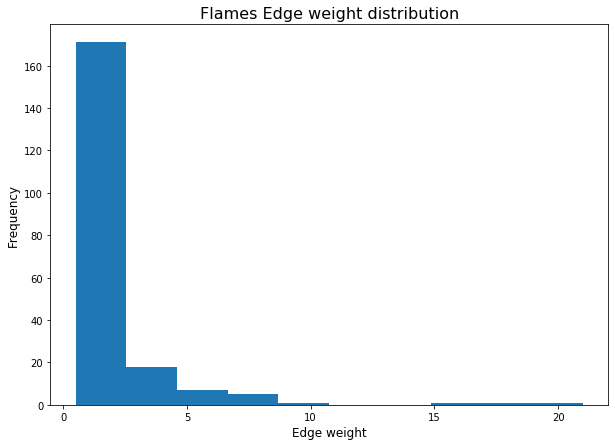

In [7]:
team = 'Flames'
evol = generate_network_evolution(team, 20182019)

print(f" # nodes: {len(evol[-1].nodes)}\n", 
      f"# edges: {len(evol[-1].edges)}\n",
      f"avg. degree: {np.mean([evol[-1].degree(n) for n in evol[-1].nodes()])}\n",
      f"avg. clustering: {nx.average_clustering(evol[-1])}\n",
      )

edge_weights = nx.get_edge_attributes(evol[-1],"weight")
fig = plt.figure(figsize=(10,7))
plt.hist([v[1] for v in edge_weights.items()])

plt.title(f"{team} Edge weight distribution", size = 16)
plt.xlabel("Edge weight", size = 12)
plt.ylabel("Frequency", size = 12)
plt.show()

In [0]:
finalG = getTop(evol[-1])
pos = getPos(finalG)
finalnodes = list(finalG.nodes())
finaledges = list(finalG.edges())
finalweights = list(nx.get_edge_attributes(finalG, 'weight').items())
finalweights = [e[1] for e in finalweights]
maxWeight = 7.5

def dropNodes(gr):
  gr.remove_nodes_from(list(set(gr.nodes())-set(finalnodes)))
  return gr

def drawNet(gr, pos, i):
  fig = plt.figure(figsize=(17,10))

  egr = dropNodes(gr.copy())
  
  weights = dict.fromkeys(nx.get_edge_attributes(finalG, 'weight'),0)
  weights.update(nx.get_edge_attributes(egr,"weight"))
  weights = [e[1] for e in weights.items()]
  weights = [w*20/maxWeight for w in weights]
  
  points = dict.fromkeys(nx.get_node_attributes(finalG,"points"),0)
  points.update(nx.get_node_attributes(egr,"points"))
  points = [p[1] for p in points.items()]
  points = [p*500/max(points) for p in points]
  
  labelpos = {}
  for k in pos.keys():
    labelpos.update({k:[pos[k][0], (pos[k][1]+0.06)]})

  nodecolor = ['darkblue' if finalG.nodes[n]["position"] == "Forward" else 'lightblue' for n in finalnodes]

  nx.draw_networkx_nodes(finalG, pos = pos, node_color = nodecolor, node_size=points)
  nx.draw_networkx_edges(finalG, pos = pos, width=weights, alpha=0.5, edge_color='grey', arrows= False if (i < 80) else True)
  nx.draw_networkx_labels(finalG, labelpos)
  
  plt.gca().spines['top'].set_visible(False)
  plt.gca().spines['bottom'].set_visible(False)
  plt.gca().spines['left'].set_visible(False)
  plt.gca().spines['right'].set_visible(False)
  plt.title(f"{team} | Game #{i+1}", size=24)
  plt.margins(x=0.1)
  # plt.show()

  fig.canvas.draw();       # draw the canvas, cache the renderer
  plt.close()
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
  image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

  return image

In [9]:
kwargs_write = {'fps':5.0, 'quantizer':'nq'}
images = [drawNet(e, pos, i) for i,e in enumerate(evol)]#[0:10])]
print(f"# of games = {len(images)}")
images = images + [images[-1]]*15
imageio.mimsave(f"./{team}_evol.gif", images, fps=5)

# of games = 82


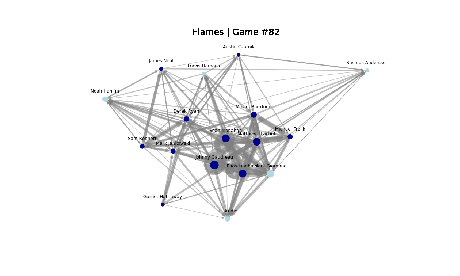

In [10]:
fig = plt.figure(figsize=(8,5));
plt.imshow(images[-1]);

plt.axis('off')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

fig.savefig(f'{team}.png', dpi = 600)
